# IF3170 Artificial Intelligence | Tugas Besar 1
Notebook ini digunakan untuk pengujian terhadap implementasi model FFNN.

Nomor Kelompok: 57

Anggota Kelompok:
- Aland Mulia Pratama (13522124)
- Christian Justin Hendrawan (13522135)
- Albert Ghazaly (13522150)

In [27]:
# Import basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load the dataset
from sklearn.datasets import fetch_openml

# Importing random
from sklearn.utils import shuffle
from sklearn.utils import check_random_state

# Importing preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Import the model
from ffnn.model import FFNN

# Set up plotting style
plt.style.use('ggplot')

## Memuat Dataset

In [28]:
def load_mnist():
    print("Loading MNIST_784 dataset...")
    
    # Fetch the dataset
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data.astype('float32')
    y = mnist.target.astype('int')
    
    # Normalize the data (scale pixel values to [0,1])
    X = X / 255.0
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=10000, random_state=42)
    
    # Reshape targets to column vectors
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encode the targets
    encoder = OneHotEncoder(sparse_output=False)
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    
    print(f"Dataset loaded: {X_train.shape[0]} training samples, "
          f"{X_test.shape[0]} test samples")
    print(f"Input dimension: {X_train.shape[1]}")
    print(f"Output classes: {y_train.shape[1]}")
    
    return X_train, X_test, y_train, y_test


In [29]:
def visualize_examples(X, y_onehot, n_examples=5):
    plt.figure(figsize=(15, 3))
    
    # Convert one-hot back to class index
    y = np.argmax(y_onehot, axis=1)
    
    for i in range(n_examples):
        plt.subplot(1, n_examples, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Loading MNIST_784 dataset...
Dataset loaded: 60000 training samples, 10000 test samples
Input dimension: 784
Output classes: 10


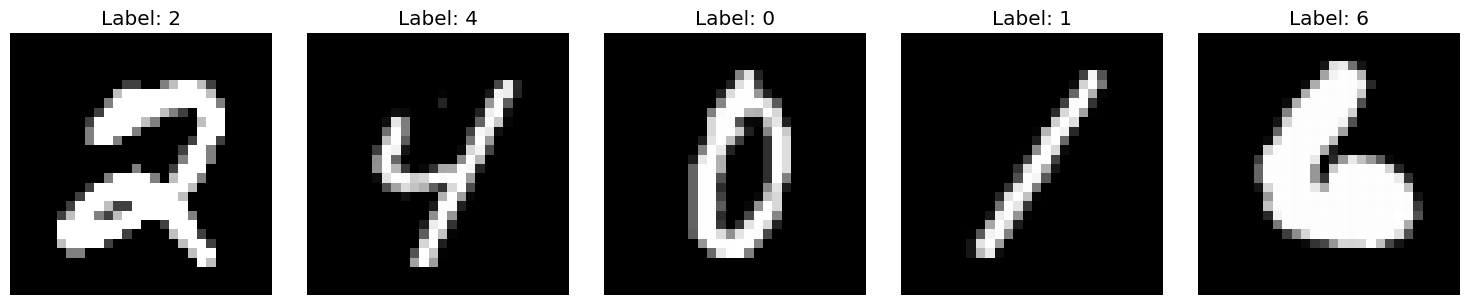

In [30]:
#Load the data and visualize examples
X_train, X_test, y_train, y_test = load_mnist()

# Visualize a few examples
visualize_examples(X_train, y_train)

In [31]:
def train_and_evaluate(X_train, X_test, y_train, y_test, 
                      hidden_layers, width_per_layer, 
                      epochs=10, learning_rate=0.01, batch_size=128):
    """
    Train a model with specified hyperparameters and return results
    
    Parameters:
    -----------
    hidden_layers : int
    Number of hidden layers (depth)
    width_per_layer : int or list
    Number of neurons per hidden layer. If int, all layers have same width.
    If list, must match length of hidden_layers.
    """
    input_size = X_train.shape[1]  # 784 for MNIST
    output_size = y_train.shape[1]  # 10 for MNIST
    
    # Record start time
    start_time = time.time()
    
    # Create model
    model = FFNN(loss='categorical_crossentropy')
    
    # Add input layer to first hidden layer
    if isinstance(width_per_layer, list):
        first_layer_width = width_per_layer[0]
    else:
        first_layer_width = width_per_layer
        
    model.add(input_size=input_size, output_size=first_layer_width, 
             activation='relu', weight_initializer='normal', std=0.1)
    
    # Add additional hidden layers
    for i in range(1, hidden_layers):
        if isinstance(width_per_layer, list):
            prev_width = width_per_layer[i-1]
            current_width = width_per_layer[i]
        else:
            prev_width = width_per_layer
            current_width = width_per_layer
            
        model.add(input_size=prev_width, output_size=current_width,
                 activation='relu', weight_initializer='normal', std=0.1)
    
    # Add output layer with softmax activation for multi-class classification
    if isinstance(width_per_layer, list):
        last_hidden_width = width_per_layer[-1]
    else:
        last_hidden_width = width_per_layer
        
    model.add(input_size=last_hidden_width, output_size=output_size,
             activation='softmax', weight_initializer='normal', std=0.1)
    
    # Print model structure
    print(f"\nTraining model with {hidden_layers} hidden layers, width: {width_per_layer}")
    model.summary()
    
    # Train model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        learning_rate=learning_rate,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=1
    )
    
    # Record end time
    training_time = time.time() - start_time
    
    # Evaluate model
    y_pred = model.forward(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_classes)
    
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    
    return {
        'model': model,
        'history': history,
        'accuracy': accuracy,
        'training_time': training_time,
        'depth': hidden_layers,
        'width': width_per_layer
    }

In [32]:
subset_size = 15000  
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Create a model
input_size = X_train.shape[1]  # 784 for MNIST
hidden_size = 64
output_size = y_train.shape[1]  # 10 for MNIST

print("Creating a simple FFNN model...")
model = FFNN(loss='categorical_crossentropy')
model.add(input_size=input_size, output_size=128, activation='relu',
         weight_initializer='normal', std=0.1)
model.add(input_size=128, output_size=64, activation='relu',
         weight_initializer='normal', std=0.1)
model.add(input_size=64, output_size=output_size, activation='softmax',
         weight_initializer='normal', std=0.1)

# Print model summary
model.summary()

# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train_subset, y_train_subset,
    batch_size=128,
    learning_rate=0.01,
    epochs=20,  # Start with a small number of epochs
    validation_data=(X_test, y_test),
    verbose=1
)

Creating a simple FFNN model...
Neural Network Architecture Summary
Total layers: 3

Layer Details:
--------------
Input shape: (784)
  Layer 1: 784 → 128 | Activation: ReLU | Parameters: 100480
  Layer 2: 128 → 64 | Activation: ReLU | Parameters: 8256
  Layer 3: 64 → 10 | Activation: Softmax | Parameters: 650

Total trainable parameters: 109386

Training the model...
Epoch 1/20 - loss: 2.1070, val_loss: 1.8394
Epoch 2/20 - loss: 1.5416, val_loss: 1.2598
Epoch 3/20 - loss: 1.0495, val_loss: 0.8948
Epoch 4/20 - loss: 0.7844, val_loss: 0.7101
Epoch 5/20 - loss: 0.6476, val_loss: 0.6111
Epoch 6/20 - loss: 0.5675, val_loss: 0.5539
Epoch 7/20 - loss: 0.5144, val_loss: 0.5054
Epoch 8/20 - loss: 0.4762, val_loss: 0.4745
Epoch 9/20 - loss: 0.4469, val_loss: 0.4482
Epoch 10/20 - loss: 0.4246, val_loss: 0.4309
Epoch 11/20 - loss: 0.4056, val_loss: 0.4114
Epoch 12/20 - loss: 0.3904, val_loss: 0.3993
Epoch 13/20 - loss: 0.3776, val_loss: 0.3940
Epoch 14/20 - loss: 0.3666, val_loss: 0.3796
Epoch 15


Evaluating on test set...


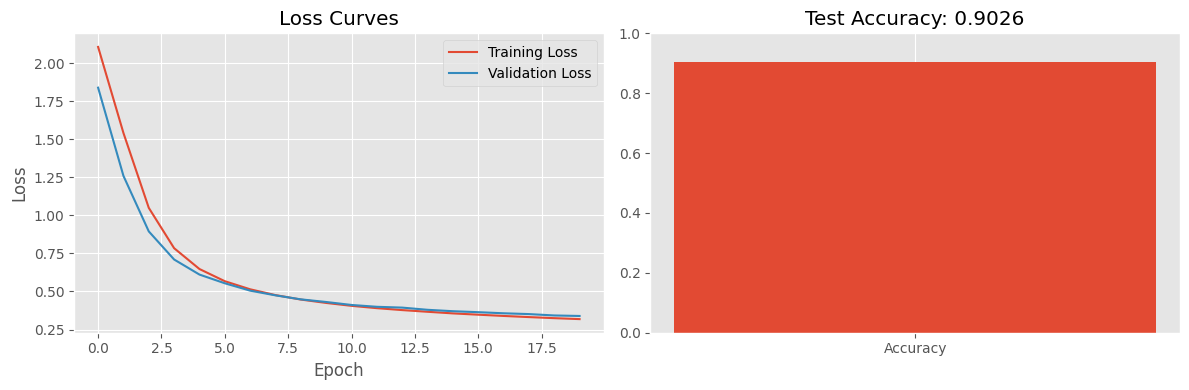

In [33]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Evaluate on test set
print("\nEvaluating on test set...")
y_pred = model.forward(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred_classes == y_test_classes)

plt.subplot(1, 2, 2)
plt.bar(['Accuracy'], [accuracy])
plt.title(f'Test Accuracy: {accuracy:.4f}')
plt.ylim(0, 1)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Oke ini kenapa output ga keluar karena lama banget banget banget
print("\nVisualizing network structure...")
model.visualize_network(figsize=(10, 6))


Visualizing network structure...


KeyboardInterrupt: 


Visualizing weight distributions...


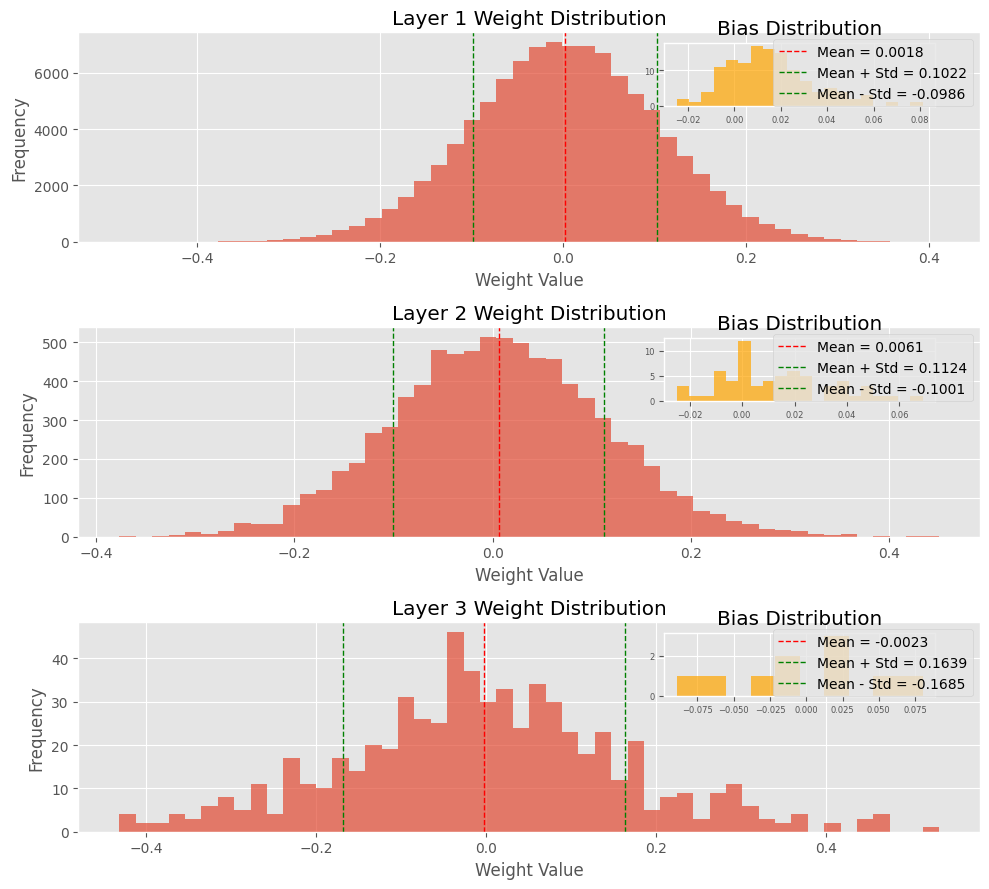

In [34]:
print("\nVisualizing weight distributions...")
model.visualize_weight_distribution()

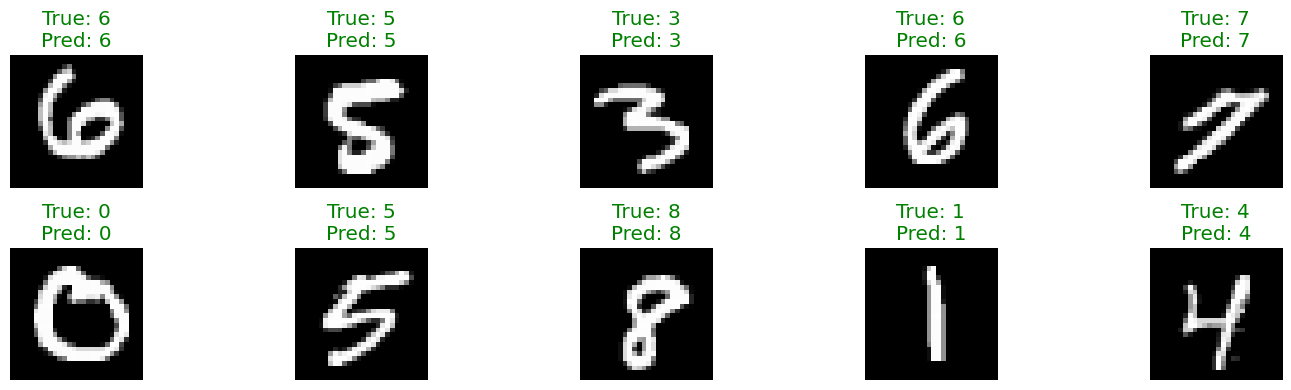

In [35]:
n_examples = 10
sample_indices = np.random.choice(len(X_test), n_examples, replace=False)
X_samples = X_test[sample_indices]
y_true_samples = np.argmax(y_test[sample_indices], axis=1)

# Get predictions
y_pred_samples = model.forward(X_samples)
y_pred_samples_classes = np.argmax(y_pred_samples, axis=1)

# Display the results
plt.figure(figsize=(15, 4))
for i in range(n_examples):
    plt.subplot(2, n_examples//2, i+1)
    plt.imshow(X_samples[i].reshape(28, 28), cmap='gray')
    
    # Green for correct, red for incorrect predictions
    color = 'green' if y_pred_samples_classes[i] == y_true_samples[i] else 'red'
    
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples_classes[i]}", 
              color=color)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# TAMAT???

In [16]:
# Memuat dataset MNIST
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser="auto")

# Mengonversi X dan y menjadi DataFrame
df_X = pd.DataFrame(X, columns=[f"pixel{i}" for i in range(X.shape[1])])
df_y = pd.DataFrame(y, columns=["label"])

data_df = pd.concat([df_X, df_y], axis=1)

# Menampilkan 5 data pertama
print("5 Data Pertama:")
print(data_df.head())

5 Data Pertama:
   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  label  
0         0

# 1. Analisis Data Eksplorasi (EDA)

Analisis Data Eksplorasi (EDA) adalah langkah penting dalam proses analisis data yang melibatkan pemeriksaan dan visualisasi kumpulan data untuk menemukan pola, tren, anomali, dan wawasan. EDA merupakan langkah awal sebelum menerapkan teknik statistik dan pembelajaran mesin yang lebih lanjut. EDA membantu Anda memahami data secara mendalam, memungkinkan Anda membuat keputusan yang tepat dan merumuskan hipotesis untuk analisis lebih lanjut.

In [3]:
# 1. Statistik Dasar dan Informasi

print("Dimensi Dataset:\n", data_df.shape)

print("\nNama Fitur:")
print(data_df.columns.tolist())

print("\nNama Fitur dan Tipe Datanya:\n")
for column, dtype in data_df.dtypes.items():
    print(f"{column}: {dtype}")

print("\nStatistik Dasar Dataset:")
print(data_df.describe())

print("\nDistribusi Label Dataset:")
print(data_df['label'].value_counts())


Dimensi Dataset:
 (70000, 785)

Nama Fitur:
['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87

In [4]:
# 2. Mengecek nilai yang hilang
print("Nilai Hilang:\n")
print(data_df.isnull().sum())

# Calculate percentage of missing values
missing_percentages = (data_df.isnull().sum() / len(data_df)) * 100
print("\nPercentase Nilai Hilang:\n")
print(missing_percentages[missing_percentages > 0])

Nilai Hilang:

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
label       0
Length: 785, dtype: int64

Percentase Nilai Hilang:

Series([], dtype: float64)


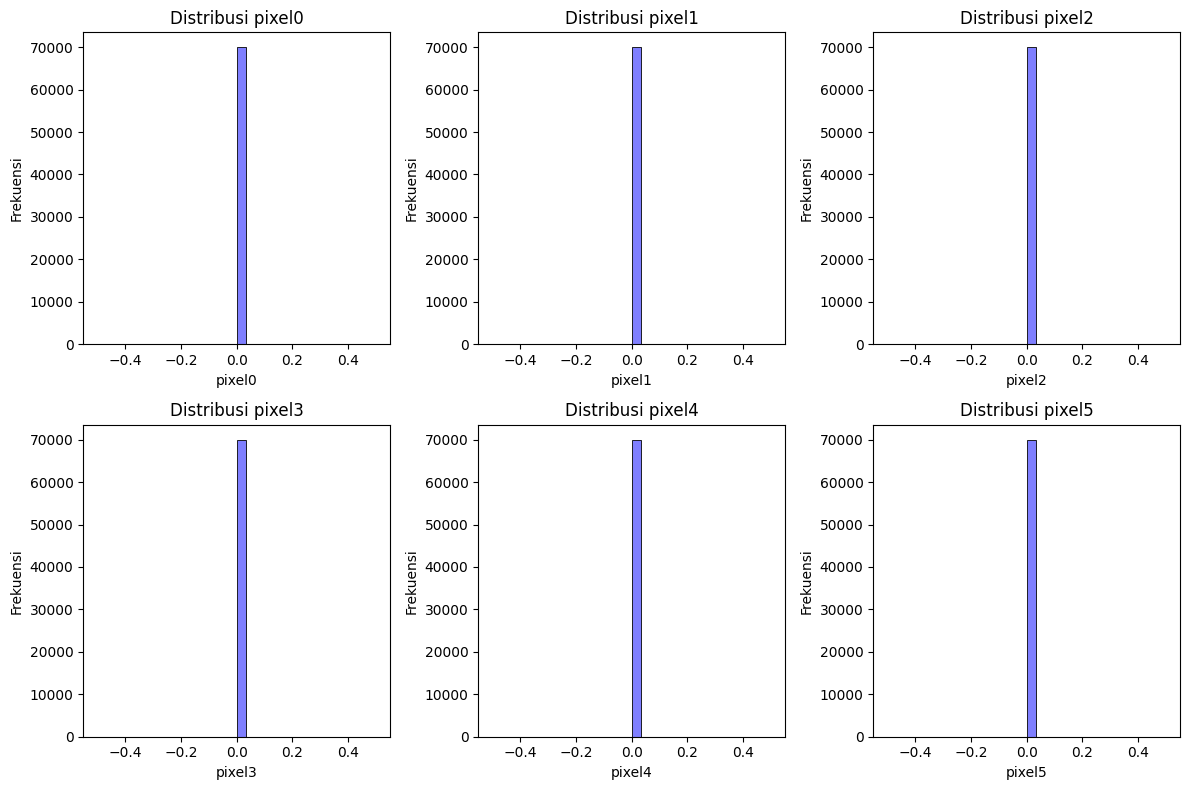

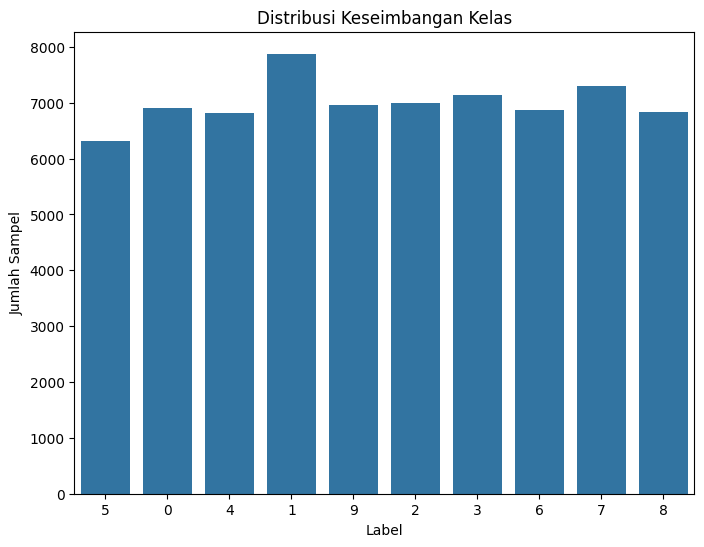

In [5]:
# 3. Visualisasi Data

# 1. Distribusi Fitur (Contoh beberapa fitur)
plt.figure(figsize=(12, 8))
for i, feature in enumerate(data_df.columns[:6], start=1):  # Limit to first 6 features
    plt.subplot(2, 3, i)
    sns.histplot(data_df[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribusi {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# 2. Keseimbangan Kelas (Distribusi Label)
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data_df)
plt.title('Distribusi Keseimbangan Kelas')
plt.xlabel('Label')
plt.ylabel('Jumlah Sampel')
plt.show()

# 2. Membagi Set Pelatihan dan Validasi

Membagi set pelatihan dan validasi berfungsi sebagai langkah diagnostik awal untuk menilai kinerja model yang kita latih. Pembagian ini dilakukan sebelum langkah pra-pemrosesan untuk menghindari kebocoran data antar set. Jika Anda ingin menggunakan k-fold cross-validation, bagilah data nanti dan lakukan pembersihan serta pra-pemrosesan secara terpisah untuk setiap pembagian.

In [6]:
# Membagi dataset menjadi set pelatihan dan validasi
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encoding setelah pembagian
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train_raw.reshape(-1, 1))
y_test = encoder.transform(y_test_raw.reshape(-1, 1))

# Menampilkan informasi tentang set pelatihan dan validasi
print("X_train shape:", X_train.shape)  # (56000, 784)
print("X_test shape:", X_test.shape)    # (14000, 784)
print("y_train shape:", y_train.shape)  # (56000, 2)
print("y_test shape:", y_test.shape)    # (14000, 2)

X_train shape: (56000, 784)
X_test shape: (14000, 784)
y_train shape: (56000, 10)
y_test shape: (14000, 10)


# 3. Pembersihan Data dan Preprocessing
Dalam proses pembersihan data, langkah yang diambil adalah membuang kolom yang seluruh nilainya unik (distinct) atau hanya memiliki satu variasi (konstan). Hal ini dilakukan karena:

1. Kolom dengan Nilai Unik (Distinct):
    
    Kolom ini tidak memberikan informasi yang berguna untuk analisis atau model pembelajaran mesin, karena setiap baris memiliki nilai yang berbeda sehingga tidak ada pola yang bisa dipelajari.
    Contoh: ID unik atau nomor seri.

2. Kolom dengan Satu Variasi (Konstan):

    Kolom ini juga tidak memberikan nilai informasi, karena semua baris memiliki nilai yang sama, sehingga kontribusinya terhadap model atau analisis adalah nol.
    Contoh: Kolom yang seluruh nilainya adalah 0 atau yes.

Proses ini membantu mengurangi dimensi data, menghilangkan fitur yang tidak relevan, dan meningkatkan efisiensi serta akurasi model.

In [7]:
# Identifikasi dan pembersihan kolom berdasarkan nilai dominan
def clean_data(X_train, X_test, threshold):
    # Mengidentifikasi kolom yang memiliki nilai dominan di X_train
    columns_to_remove = []
    for col in range(X_train.shape[1]):
        # Hitung proporsi nilai dominan
        values, counts = np.unique(X_train[:, col], return_counts=True)
        max_proportion = np.max(counts) / X_train.shape[0]
        
        # Jika proporsi nilai dominan lebih dari threshold, tambahkan kolom ke daftar penghapusan
        if max_proportion > threshold:
            columns_to_remove.append(col)
    
    # Menghapus kolom tersebut di X_train dan X_test
    X_train_cleaned = np.delete(X_train, columns_to_remove, axis=1)
    X_test_cleaned = np.delete(X_test, columns_to_remove, axis=1)
    
    return X_train_cleaned, X_test_cleaned

# Pembersihan data
X_train, X_test = clean_data(X_train, X_test, threshold=0.3)

# Menampilkan informasi tentang set pelatihan dan validasi
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (56000, 8)
X_test shape: (14000, 8)


# 4. Pengujian Terhadap Implementasi FFNN (Feed Forward Neural Network)

Analisis ini bertujuan mengevaluasi pengaruh berbagai hyperparameter pada kinerja model FFNN. Pertama, dilakukan analisis pengaruh jumlah layer (depth) dan jumlah neuron per layer (width) terhadap hasil prediksi dan grafik loss pelatihan. Kedua, diuji pengaruh fungsi aktivasi hidden layer (kecuali softmax) pada hasil prediksi, grafik loss, serta distribusi bobot dan gradien. Ketiga, dilakukan analisis variasi learning rate untuk membandingkan hasil prediksi, grafik loss, dan distribusi bobot atau gradien. Keempat, pengaruh metode inisialisasi bobot dianalisis dengan membandingkan hasil prediksi, grafik loss, serta distribusi parameter. Terakhir, hasil prediksi model dibandingkan dengan library sklearn MLP menggunakan hyperparameter yang sama untuk menilai perbedaan kinerja.

In [8]:
def train_and_evaluate(
    X_train, X_test, y_train, y_test,
    hidden_layers, width_per_layer,
    epochs, learning_rate
):
    """
    Train and evaluate an FFNN model.

    Parameters:
    - X_train, X_test: np.ndarray, feature data for training and testing.
    - y_train, y_test: np.ndarray, target data for training and testing (one-hot encoded).
    - hidden_layers: int, number of hidden layers.
    - width_per_layer: int, number of neurons in each hidden layer.
    - epochs: int, number of training epochs.
    - learning_rate: float, learning rate for the model.

    Returns:
    - history: dict, training history with loss and validation loss.
    - accuracy: float, accuracy on the test dataset.
    - model: trained FFNN instance.
    """

    print("\nCreating and configuring the neural network...")
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]

    # Initialize the FFNN model
    model = FFNN(loss='categorical_crossentropy')

    # Add input and hidden layers
    for i in range(hidden_layers):
        model.add(
            input_size=input_size,
            output_size=width_per_layer,
            activation='relu',
            weight_initializer='normal',
            mean=0,
            std=0.1
        )

    # Add output layer
    model.add(
        input_size=width_per_layer,
        output_size=output_size,
        activation='softmax',
        weight_initializer='normal',
        mean=0,
        std=0.1
    )
    
    # Visualize initial network structure
    print("\nVisualizing initial network structure...")
    model.visualize_network(figsize=(12, 8))
    
    # Visualize initial weight distribution
    print("\nVisualizing initial weight distribution...")
    model.visualize_weight_distribution()
    

    # Print model summary
    model.summary()

    print("\nTraining the model...")
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        learning_rate=learning_rate,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=1
    )

    print("\nEvaluating the model on the test set...")
    y_pred = model.forward(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_classes)

    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracy as a bar chart
    plt.subplot(1, 2, 2)
    plt.bar(['Accuracy'], [accuracy], color='green')
    plt.title(f'Test Accuracy: {accuracy:.4f}')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

        # Visualize trained network structure
    print("\nVisualizing trained network structure...")
    model.visualize_network(figsize=(12, 8))
    
    # Visualize final weight distribution
    print("\nVisualizing final weight distribution...")
    model.visualize_weight_distribution()
    
    # Visualize gradient distribution
    print("\nVisualizing gradient distribution...")
    # First do a forward/backward pass to compute gradients
    y_pred = model.forward(X_test[:32])  # Use a batch
    model.backward(y_test[:32], y_pred)
    model.visualize_gradient_distribution()

    return history, accuracy, model


## a) Pengaruh depth (banyak layer) dan width (banyak neuron per layer)
Pada analisis ini, model FFNN akan diuji dengan 3 variasi kombinasi width (jumlah neuron per layer) dengan jumlah layer (depth) tetap, serta 3 variasi kombinasi depth (jumlah layer) dengan jumlah neuron (width) pada setiap layer tetap. Tujuan dari analisis ini adalah untuk:
- Membandingkan hasil akhir prediksi dari setiap variasi kombinasi depth dan width.
- Membandingkan grafik loss selama pelatihan untuk menilai pengaruh konfigurasi arsitektur terhadap proses konvergensi model.

X_train shape: (56000, 8)
X_test shape: (14000, 8)
y_train shape: (56000, 10)
y_test shape: (14000, 10)

Creating and configuring the neural network...

Visualizing initial network structure...


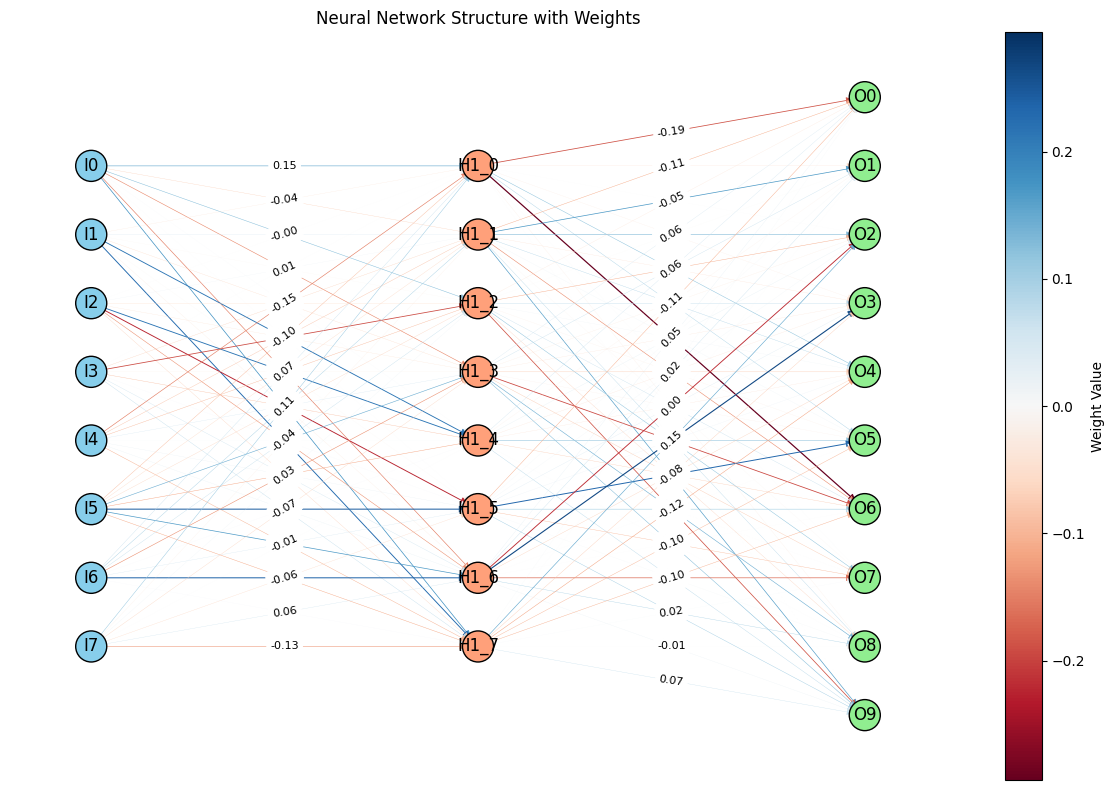


Visualizing initial weight distribution...


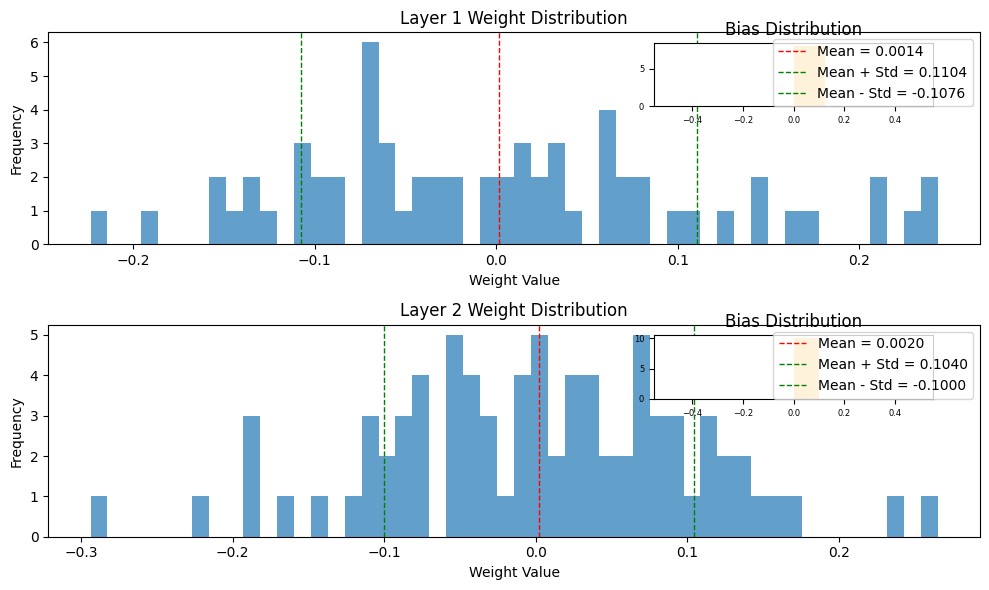

Neural Network Architecture Summary
Total layers: 2

Layer Details:
--------------
Input shape: (8)
  Layer 1: 8 → 8 | Activation: ? | Parameters: 72
  Layer 2: 8 → 10 | Activation: ? | Parameters: 90

Total trainable parameters: 162

Training the model...
Epoch 1/20 - loss: nan, val_loss: nan
Epoch 2/20 - loss: nan, val_loss: nan
Epoch 3/20 - loss: nan, val_loss: nan
Epoch 4/20 - loss: nan, val_loss: nan
Epoch 5/20 - loss: nan, val_loss: nan
Epoch 6/20 - loss: nan, val_loss: nan
Epoch 7/20 - loss: nan, val_loss: nan
Epoch 8/20 - loss: nan, val_loss: nan
Epoch 9/20 - loss: nan, val_loss: nan
Epoch 10/20 - loss: nan, val_loss: nan
Epoch 11/20 - loss: nan, val_loss: nan
Epoch 12/20 - loss: nan, val_loss: nan
Epoch 13/20 - loss: nan, val_loss: nan
Epoch 14/20 - loss: nan, val_loss: nan
Epoch 15/20 - loss: nan, val_loss: nan
Epoch 16/20 - loss: nan, val_loss: nan
Epoch 17/20 - loss: nan, val_loss: nan
Epoch 18/20 - loss: nan, val_loss: nan
Epoch 19/20 - loss: nan, val_loss: nan
Epoch 20/20

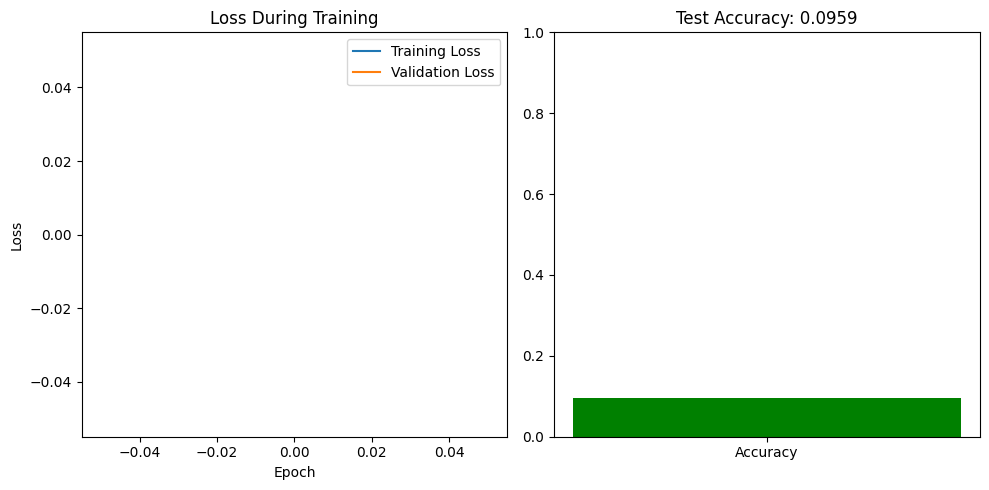


Visualizing trained network structure...


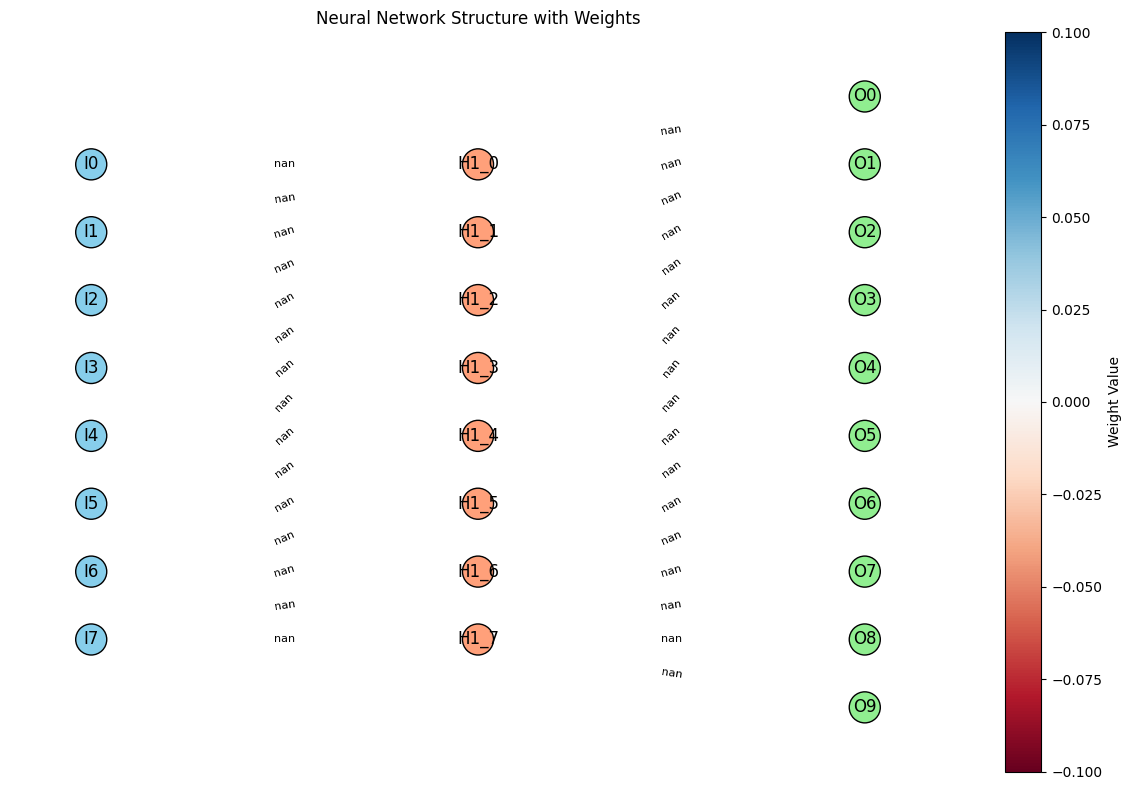


Visualizing final weight distribution...


ValueError: autodetected range of [nan, nan] is not finite

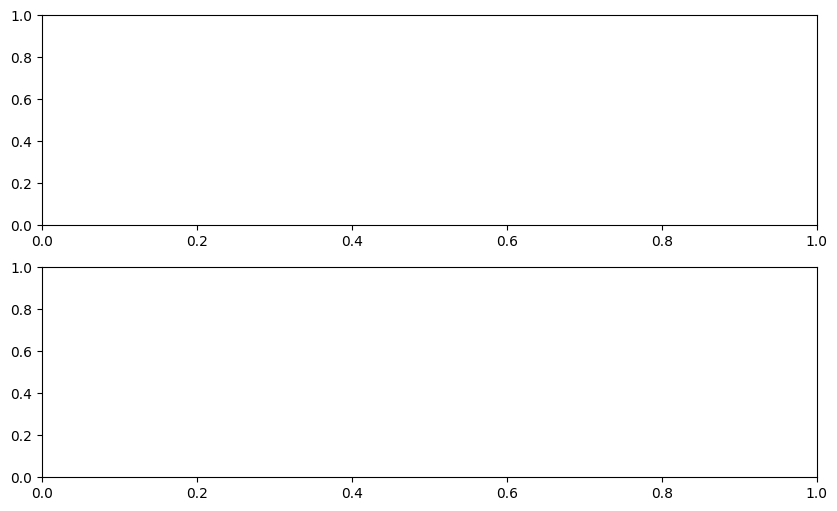

In [11]:
# Check data shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Train and evaluate
history, accuracy, model = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    hidden_layers=1, width_per_layer=8,
    epochs=20, learning_rate=0.01
)
